In [1]:
import gzip
import joblib
import pandas
import pickle
import seaborn
import tqdm

from lib.models.generic_v0.model import map_params

In [2]:
import sys

util_dir = "./sprint-0-explicit-mdps/"
sys.path.append(util_dir)

import util

In [3]:
fixed_dag_size = pandas.read_pickle(
    "5-generated-mdps/fixed.pkl.gz"
).dag_size_limit.drop_duplicates()
assert len(fixed_dag_size) == 1
fixed_dag_size = fixed_dag_size.iloc[0]
fixed_dag_size

6

In [4]:
mdps = pandas.read_pickle("5-generated-mdps/success.pkl.gz")
mdps

max_dag_size = mdps.query(
    'problem == "v1+fc+n" and protocol == "bitcoin"'
).dag_size_limit.max()
max_dag_size

biggest_v1 = mdps.query(
    f'problem == "v1+fc+n" and protocol == "bitcoin" and dag_size_limit in [{max_dag_size}]'
)
biggest_v1

ref_models = mdps.query(
    f'problem.str.startswith("ref") and dag_size_limit in [{max_dag_size}]'
)
ref_models

mdps = pandas.concat([biggest_v1, ref_models])
mdps[["problem", "protocol", "dag_size_limit", "mdp"]]

,problem,protocol,dag_size_limit,mdp
82,v1+fc+n,bitcoin,11,7bd7931f
113,ref-fc16,bitcoin,11,50bc0b4c
124,ref-aft20,bitcoin,11,601c2d1c


In [5]:
networks = []
for alpha in range(20, 46, 5):
    # for alpha in [33]:
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [6]:
horizon = 100
stop_delta = (
    0.0001  # value iteration stops when no value estimate changes more than this value
)

In [7]:
def optimize(network, idx, row):
    with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
        emdp = pickle.load(f)
        emdp = map_params(emdp, **network)
        oae = util.optimize_and_evaluate(emdp, eps=stop_delta, horizon=horizon)
        return row.to_dict() | dict(horizon=horizon) | network | oae


def generate_jobs():
    for network in networks:
        for idx, row in mdps.iterrows():
            # if row['size'] > 1000:
            #    continue
            yield joblib.delayed(optimize)(network, idx, row)


jobs = list(generate_jobs())
generate_solutions = joblib.Parallel(return_as="generator_unordered", n_jobs=6)(jobs)
with_progress = tqdm.tqdm(generate_solutions, total=len(jobs))
df = pandas.DataFrame(with_progress)
df.to_pickle("7-value-iterations.pkl.gz")
df

  0%|                                                                                                                                                                  | 0/36 [00:00<?, ?it/s]

  3%|████▎                                                                                                                                                     | 1/36 [00:01<00:50,  1.44s/it]

  6%|████████▌                                                                                                                                                 | 2/36 [00:01<00:22,  1.51it/s]

 11%|█████████████████                                                                                                                                         | 4/36 [00:02<00:13,  2.39it/s]

 14%|█████████████████████▍                                                                                                                                    | 5/36 [00:02<00:17,  1.79it/s]

 19%|█████████████████████████████▉                                                                                                                            | 7/36 [00:04<00:17,  1.61it/s]

 22%|██████████████████████████████████▏                                                                                                                       | 8/36 [00:04<00:17,  1.64it/s]

 25%|██████████████████████████████████████▌                                                                                                                   | 9/36 [00:07<00:28,  1.07s/it]

 28%|██████████████████████████████████████████▌                                                                                                              | 10/36 [00:08<00:29,  1.13s/it]

 31%|██████████████████████████████████████████████▍                                                                                                         | 11/36 [06:13<43:05, 103.41s/it]

 33%|███████████████████████████████████████████████████                                                                                                      | 12/36 [06:15<29:42, 74.25s/it]

 36%|███████████████████████████████████████████████████████▎                                                                                                 | 13/36 [06:15<20:13, 52.75s/it]

 39%|███████████████████████████████████████████████████████████▌                                                                                             | 14/36 [06:16<13:47, 37.60s/it]

 42%|███████████████████████████████████████████████████████████████▊                                                                                         | 15/36 [06:18<09:26, 26.99s/it]

 44%|████████████████████████████████████████████████████████████████████                                                                                     | 16/36 [06:19<06:26, 19.34s/it]

 47%|████████████████████████████████████████████████████████████████████████▎                                                                                | 17/36 [06:24<04:46, 15.10s/it]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 18/36 [06:26<03:21, 11.17s/it]

 53%|████████████████████████████████████████████████████████████████████████████████▊                                                                        | 19/36 [06:27<02:20,  8.25s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████                                                                    | 20/36 [07:42<07:29, 28.07s/it]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 21/36 [07:44<05:03, 20.25s/it]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 22/36 [07:45<03:24, 14.59s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 23/36 [07:58<03:01, 13.97s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 24/36 [08:00<02:05, 10.42s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 25/36 [08:01<01:25,  7.74s/it]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 26/36 [09:05<04:04, 24.42s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 27/36 [09:07<02:39, 17.75s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 28/36 [09:08<01:42, 12.86s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 29/36 [14:56<13:13, 113.39s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 30/36 [14:59<08:01, 80.30s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 31/36 [15:01<04:43, 56.70s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 32/36 [16:02<03:52, 58.11s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 33/36 [16:03<02:02, 40.83s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 34/36 [17:53<02:03, 61.68s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 35/36 [18:04<00:46, 46.40s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [19:27<00:00, 57.57s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [19:27<00:00, 32.44s/it]

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,vi_time,vi_max_value,ss_reachable,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value
0,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,11,136,...,0.981049,28.617419,46,46,0.058214,2,0.099000,0.200000,1.042523,19.786528
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,11,136,...,1.012386,28.768440,46,46,0.058630,2,0.099000,0.200000,1.074217,19.786528
2,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,11,181,...,1.144914,28.834005,75,75,0.062087,2,0.198000,0.200000,1.213808,19.790269
3,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,11,181,...,1.513856,28.962645,75,75,0.062317,2,0.198000,0.200000,1.584435,19.790269
4,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,11,181,...,1.374723,33.808164,75,75,0.002185,2,0.247500,0.250000,1.384925,24.740347
5,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,11,136,...,1.436441,33.522305,46,46,0.001675,2,0.123750,0.250000,1.441322,24.734313
6,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,11,136,...,1.274507,35.095240,55,55,0.001769,2,0.114850,0.267891,1.279052,26.679880
7,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,11,181,...,1.930808,35.346304,83,83,0.004143,2,0.201594,0.267955,1.943534,26.770108
8,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,11,181,...,2.339549,39.217605,79,79,0.002200,2,0.237786,0.307621,2.350620,30.583646
9,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,11,136,...,1.270690,38.816870,51,51,0.001663,2,0.136740,0.307112,1.275151,30.403272


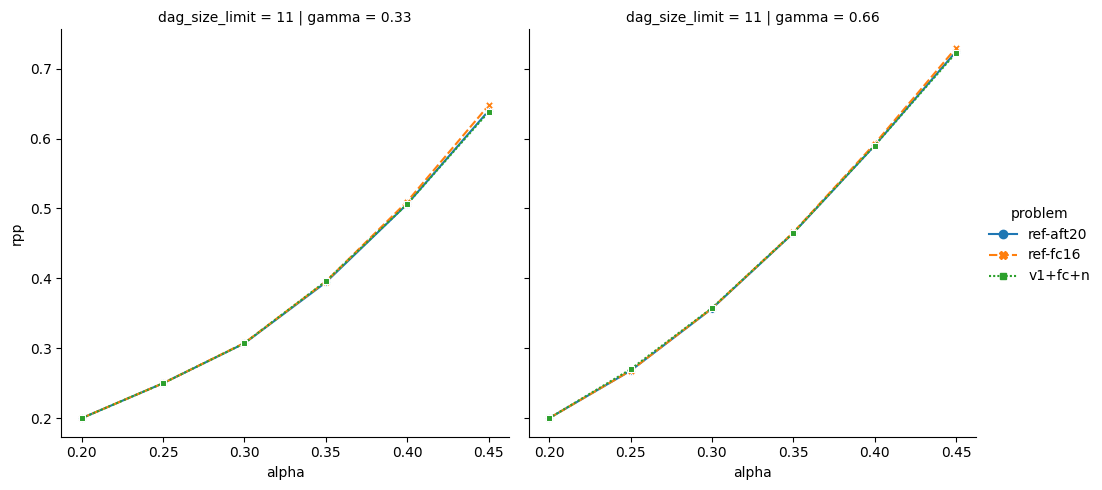

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="rpp",
    hue="problem",
    style="problem",
    markers=True,
    col="gamma",
    row="dag_size_limit",
)

In [9]:
!rm -f 7-rpp-for-alpha.csv

In [10]:
rpp_of_alpha = df.assign(
    column=lambda d: [
        f"{r.problem}:{r.protocol}:gamma{str(r.gamma)[2:]}:dsl{r.dag_size_limit:02d}"
        for _, r in d.iterrows()
    ]
).pivot(index="alpha", columns="column", values="rpp")
rpp_of_alpha.to_csv("7-rpp-of-alpha.csv")
rpp_of_alpha

column,ref-aft20:bitcoin:gamma33:dsl11,ref-aft20:bitcoin:gamma66:dsl11,ref-fc16:bitcoin:gamma33:dsl11,ref-fc16:bitcoin:gamma66:dsl11,v1+fc+n:bitcoin:gamma33:dsl11,v1+fc+n:bitcoin:gamma66:dsl11
alpha,,,,,,
0.20,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
0.25,0.250000,0.267891,0.250000,0.267955,0.250000,0.269965
0.30,0.307112,0.356804,0.307621,0.357094,0.307255,0.357643
0.35,0.394317,0.464844,0.395463,0.465812,0.395922,0.465228
0.40,0.506425,0.590155,0.510004,0.592629,0.506380,0.590114
0.45,0.639870,0.724647,0.647508,0.729807,0.638149,0.722928
